In [1]:
import random
import wave
import numpy as np
import torchaudio
import ChatTTS
from scipy.io.wavfile import write
import librosa

# from zh_normalization import TextNormalizer
import logging
import torch
import os
from IPython.display import Audio

torch._dynamo.config.cache_size_limit = 64
torch._dynamo.config.suppress_errors = True
torch.set_float32_matmul_precision('high')
logging.basicConfig(level=logging.DEBUG)

/Users/charslee/miniconda3/envs/torch/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#模型下载
from modelscope import snapshot_download
model_dir = snapshot_download('mirror013/ChatTTS')

# 加载模型
chat = ChatTTS.Chat()
chat.load_models(
    source="local",
    local_path=model_dir,
    device='cpu',
    compile=False,
)

SEED = 1397
torch.manual_seed(SEED) # 音色种子
# load from local file if exists
if os.path.exists('spk_emb.npy'):
    spk_emb = torch.load('spk_emb.npy',map_location='cpu')
else:
    spk_emb = chat.sample_random_speaker()

params_infer_code = {
    'spk_emb': spk_emb,
    'temperature': 0.1,
    'top_P': 0.7,
    'top_K': 20,
}

# params_refine_text = {}
params_refine_text = {'prompt': '[oral_0][laugh_0][break_0]'}


# 对文本进行预处理
new_texts = []


def filter_punctuation(text):
    allowed_punctuations = {".", ",", "!", "?", "，", "。", "！", "？"," "}
    new_text = ""
    for char in text:
        if char.isalnum() or char in allowed_punctuations:
            new_text += char
    return new_text

2024-06-21 09:45:10,344 - modelscope - INFO - PyTorch version 2.1.0 Found.
2024-06-21 09:45:10,345 - modelscope - INFO - Loading ast index from /Users/charslee/.cache/modelscope/ast_indexer
2024-06-21 09:45:10,405 - modelscope - INFO - Loading done! Current index file version is 1.13.3, with md5 8e4efa69aee288a831cd8dd27b421a93 and a total number of 972 components indexed
INFO:ChatTTS.core:Load from local: /Users/charslee/.cache/modelscope/hub/mirror013/ChatTTS
INFO:ChatTTS.core:vocos loaded.
INFO:ChatTTS.core:dvae loaded.
INFO:ChatTTS.core:gpt loaded.
INFO:ChatTTS.core:decoder loaded.
INFO:ChatTTS.core:tokenizer loaded.
INFO:ChatTTS.core:All initialized.


In [3]:
# torch.manual_seed(SEED) # 推理种子
text = "接下来,杨叔，借我看一下现场地图。他肯定穿过了前面的那扇门，不可能在这么小的地方晃悠了两小时。"
torch.manual_seed(SEED)
all_wavs = chat.infer([filter_punctuation(text)], use_decoder=True,
                params_infer_code=params_infer_code,
                skip_refine_text=True,
                params_refine_text=params_refine_text,
                do_text_normalization=False)

# 确保所有数组的维度都是 (1, N)，然后进行合并
combined_wavs = np.concatenate(all_wavs, axis=1)
print(combined_wavs.shape)

# # Save the generated audio 
torchaudio.save("output.wav", torch.from_numpy(combined_wavs), 24000, bits_per_sample=16,encoding='PCM_S')
Audio("output.wav")
# save the generated uncompressed audio
np.save("uncompressed_output.npy", combined_wavs[0])

INFO:ChatTTS.core:All initialized.
 16%|█▌        | 324/2048 [00:12<01:06, 25.99it/s]


mel shape is torch.Size([1, 100, 648])
(1, 165632)


INFO:ChatTTS.core:All initialized.
 16%|█▌        | 324/2048 [00:12<01:07, 25.58it/s]


mel shape: torch.Size([1, 100, 648])


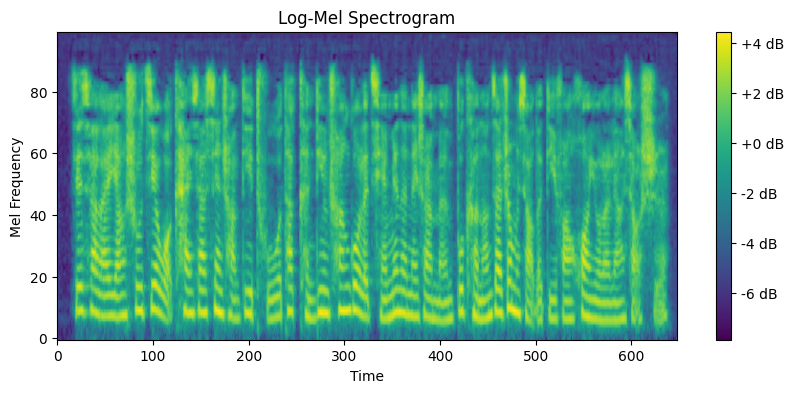

In [4]:
# 获取Mel频谱图
from matplotlib import pyplot as plt


torch.manual_seed(SEED)
origin_mel = chat.infer([filter_punctuation(text)], use_decoder=True,
                params_infer_code=params_infer_code,
                skip_refine_text=True,
                params_refine_text=params_refine_text,
                do_text_normalization=False,
                return_mel_spec=True)[0]
print(f"mel shape: {origin_mel.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(origin_mel[0].detach().numpy(), aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')

# 将单声道的Mel频谱图保存在本地
torch.save(origin_mel[0], 'origin_mel_mono.pt')

waveforme shape: torch.Size([1, 165632]) and smaplte rate: 24000
audio mel spec shape: torch.Size([1, 100, 648])


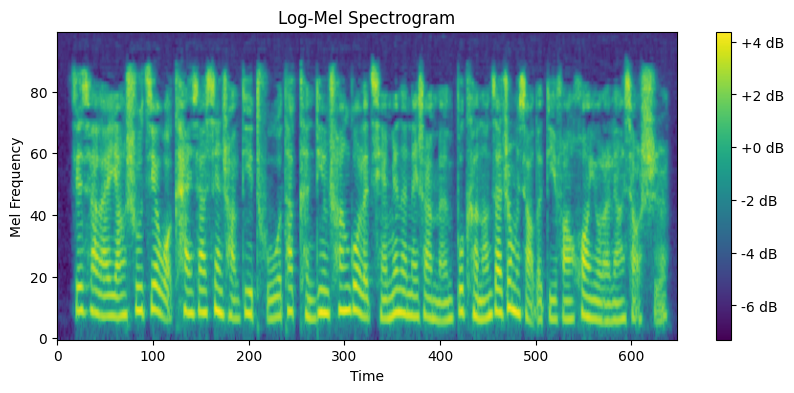

In [5]:
# 重新加载回mel频谱图
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=24000,
    n_fft=1024,
    hop_length=256,
    n_mels=100,
    center=True,
    power=1,
)

def safe_log(x: torch.Tensor, clip_val: float = 1e-7) -> torch.Tensor:
    """
    Computes the element-wise logarithm of the input tensor with clipping to avoid near-zero values.

    Args:
        x (Tensor): Input tensor.
        clip_val (float, optional): Minimum value to clip the input tensor. Defaults to 1e-7.

    Returns:
        Tensor: Element-wise logarithm of the input tensor with clipping applied.
    """
    return torch.log(torch.clip(x, min=clip_val))

waveforme,sr = torchaudio.load("output.wav")
print(f"waveforme shape: {waveforme.shape} and smaplte rate: {sr}")
audio_mel_spec = mel_spec(waveforme)
audio_mel_spec = safe_log(audio_mel_spec)

print(f"audio mel spec shape: {audio_mel_spec.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(audio_mel_spec[0].detach().numpy(), aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [6]:
# 对比二者的Mel频谱图
print(origin_mel[0])
print(audio_mel_spec[0])

tensor([[-5.5845, -5.5093, -6.0489,  ..., -6.4285, -6.4072, -4.6236],
        [-5.7381, -6.1531, -6.4828,  ..., -5.2679, -5.4848, -5.5730],
        [-5.8572, -6.2601, -6.5179,  ..., -4.9179, -5.2366, -5.3580],
        ...,
        [-6.5648, -6.3609, -6.0029,  ..., -5.4352, -5.3949, -5.0336],
        [-6.4253, -5.9173, -5.9331,  ..., -6.0273, -6.1139, -5.6247],
        [-6.3541, -6.0549, -6.3131,  ..., -6.7761, -7.2494, -6.5715]],
       grad_fn=<SelectBackward0>)
tensor([[-4.7537, -4.9101, -5.4975,  ..., -6.2952, -5.4839, -5.7606],
        [-6.2012, -5.6588, -6.3299,  ..., -5.3627, -5.4709, -5.8695],
        [-5.6616, -5.8624, -6.3427,  ..., -4.8146, -4.8818, -4.8991],
        ...,
        [-6.0484, -5.8139, -5.7647,  ..., -5.4706, -5.3487, -5.0529],
        [-5.5338, -5.5670, -5.7145,  ..., -5.9217, -6.0659, -5.7126],
        [-5.6867, -5.5555, -5.7657,  ..., -6.1595, -6.1504, -5.8795]])


In [7]:
import torch

def compare_tensors(*tensors):
    """
    判断传入的多个Tensor是否相同。
    
    首先检查所有Tensor的形状是否一致，如果不一致则直接返回False并打印具体原因。
    然后比较每个元素是否相同，有任何不同则返回False并打印具体原因。
    如果所有Tensor形状相同且每个元素都相同，则返回True。
    
    参数:
    *tensors: 可变数量的Tensor参数。
    
    返回:
    bool: 所有Tensor相同返回True，否则返回False。
    """
    # 检查形状是否全部相同
    shapes = [tensor.shape for tensor in tensors]
    if len(set(shapes)) != 1:
        print("Tensors do not have the same shape. Shapes are:", shapes)
        return False
    
    # 获取第一个Tensor作为基准进行值的比较
    reference_tensor = tensors[0]
    
    # 比较每个Tensor的每个元素是否与基准Tensor相同
    for i, tensor in enumerate(tensors):
        if not torch.equal(tensor, reference_tensor):
            print(f"Tensor {i} is not equal to the reference tensor.")
            return False
            
    return True

print(f"audio mel spec shape: {compare_tensors(audio_mel_spec,origin_mel)}")

Tensor 1 is not equal to the reference tensor.
audio mel spec shape: False


In [8]:
# 尝试再重新生成音频信号
import torch
from IPython.display import Audio

from vocos import Vocos

model = Vocos.from_hparams("/private/tmp/ChatTTS/config/vocos.yaml").eval()
model.load_state_dict(torch.load("/private/tmp/ChatTTS/asset/Vocos.pt"))

with torch.no_grad():
    audio = model.decode(audio_mel_spec[None:None: 646])
Audio(audio.cpu().numpy(), rate=24000)

In [9]:

import torch

def compute_similarity(tensor1, tensor2):
    """
    计算两个形状相同的Tensor之间的相似率。
    
    首先检查两个Tensor的形状是否一致，如果不一致则抛出ValueError。
    然后计算两个Tensor之间的差异（绝对差值之和），并基于此计算差异率。
    最后返回1减去差异率作为相似率，范围从0到1，值越接近1表示两个Tensor越相似。
    
    参数:
    tensor1 (torch.Tensor): 第一个Tensor。
    tensor2 (torch.Tensor): 第二个Tensor。
    
    返回:
    float: 两个Tensor的相似率，范围在0到1之间。
    
    抛出:
    ValueError: 如果输入的两个Tensor形状不同。
    """
    if tensor1.shape != tensor2.shape:
        raise ValueError("Input tensors must have the same shape.")
    
    # 现在两个张量形状相同，计算绝对差值
    abs_diff = torch.abs(tensor1 - tensor2)
    
    # 找到所有差异中的最大值，用于归一化
    max_diff = abs_diff.max().item()
    
    # 避免除以零的情况
    if max_diff == 0:
        return 1.0  # 如果没有差异，认为是完全相同，相似率为1
    
    # 归一化差异值
    normalized_diff = abs_diff / max_diff
    
    # 计算平均归一化差异作为相似率的逆指标，然后取其补数得到相似率
    similarity_rate = 1 - normalized_diff.mean().item()
    
    return similarity_rate

similarity = compute_similarity(audio_mel_spec,origin_mel)
print(f"The similarity rate between the two tensors is: {similarity:.4f}")

The similarity rate between the two tensors is: 0.9486


## 比较RVC换声后的Mel频谱图

rvc_waveforme shape: torch.Size([1, 165120]) and smaplte rate: 24000
rvc_audio_mel_spec shape: torch.Size([1, 100, 648])
audio mel spec shape: torch.Size([1, 100, 648])


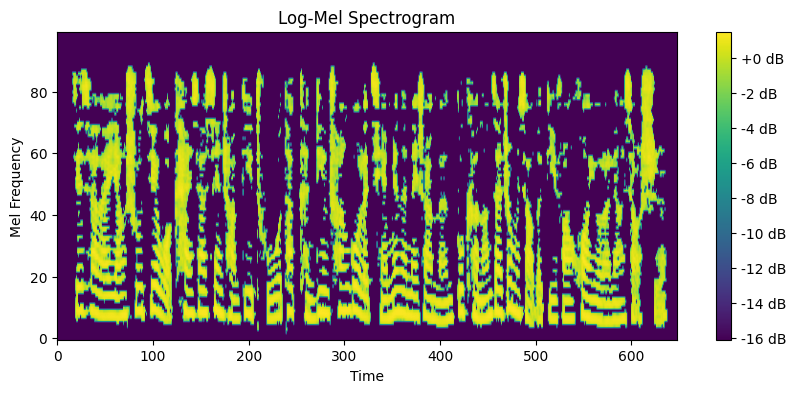

tensor([[[-16.1181, -16.1181, -16.1181,  ..., -16.1181, -16.1181, -16.1181],
         [-16.1181, -16.1181, -16.1181,  ..., -16.1181, -16.1181, -16.1181],
         [-16.1181, -16.1181, -16.1181,  ..., -16.1181, -16.1181, -16.1181],
         ...,
         [-16.1181, -16.1181, -16.1181,  ..., -16.1181, -16.1181, -16.1181],
         [-16.1181, -16.1181, -16.1181,  ..., -16.1181, -16.1181, -16.1181],
         [-16.1181, -16.1181, -16.1181,  ..., -16.1181, -16.1181, -16.1181]]])


In [10]:
rvc_audio_path = "record.wav"

rvc_waveforme,sr = torchaudio.load(rvc_audio_path)
Audio(rvc_audio_path)

print(f"rvc_waveforme shape: {rvc_waveforme.shape} and smaplte rate: {sr}")
rvc_audio_mel_spec = mel_spec(rvc_waveforme)
rvc_audio_mel_spec = safe_log(audio_mel_spec)
print(f"rvc_audio_mel_spec shape: {rvc_audio_mel_spec.shape}")

print(f"audio mel spec shape: {audio_mel_spec.shape}")
plt.figure(figsize=(10, 4))
plt.imshow(rvc_audio_mel_spec[0].detach().numpy(), aspect='auto', origin='lower')
plt.title('Log-Mel Spectrogram')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.colorbar(format='%+2.0f dB')
plt.show()
print(rvc_audio_mel_spec)
Audio(rvc_audio_path)

In [11]:
# 跟原始的差异率
print('跟原始的差异率',compute_similarity(origin_mel, rvc_audio_mel_spec))

# 跟保存后的差异率
print('跟保存后的差异率',compute_similarity(audio_mel_spec, rvc_audio_mel_spec))

跟原始的差异率 0.44571274518966675
跟保存后的差异率 0.39522796869277954


In [12]:
# 将换声后的Mel频谱图再次转回音频信号
with torch.no_grad():
    audio = model.decode(rvc_audio_mel_spec)
Audio(audio.cpu().numpy(), rate=24000)

# 直接获取推理出来的token并保存到本地

In [15]:
torch.manual_seed(SEED)
infer_result = chat.infer_debug(text = [filter_punctuation(text)],params_infer_code=params_infer_code)

INFO:ChatTTS.core:All initialized.
 16%|█▌        | 324/2048 [00:13<01:09, 24.66it/s]


In [26]:
print(infer_result['hiddens'][0].shape)
Audio(data=infer_result['wav'][0],rate=24000)

torch.Size([324, 768])
